# Forecasting exercise for SARIMA
Feb 28th 2022

In [104]:
import sys
print(sys.executable)
import numpy as np
import pandas as pd
import os
print(os.getcwd())
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error as mape
import pmdarima as pm #help us to select p,d,q
import warnings
warnings.filterwarnings('ignore')

/home/razielar/miniconda3/envs/time-series/bin/python
/home/razielar/Documents/git_rep/Machine_learning/time_series_forecasting/coursera_time_series/week_3/2_arima_sarima_models


In [118]:
# Custom functions:
import src.colorsetup
from src.timeseriesFunctions import plot_time_series, get_years, dickey_fuller_test, mape, cross_validate 

ImportError: cannot import name 'mape' from 'src.timeseriesFunctions' (/home/razielar/Documents/git_rep/Machine_learning/time_series_forecasting/coursera_time_series/week_3/2_arima_sarima_models/src/timeseriesFunctions.py)

## Input data

In [10]:
data_path = 'https://vincentarelbundock.github.io/Rdatasets/csv/datasets/sunspot.year.csv'
data= pd.read_csv(data_path, usecols= ['time', 'value'], index_col= 'time', parse_dates= ['time'])
data

,value
time,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0
...,...
1984-01-01,45.9
1985-01-01,17.9
1986-01-01,13.4


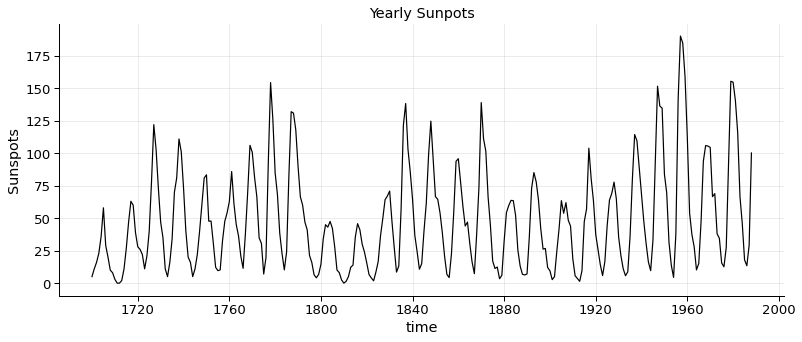

In [14]:
plot_time_series(data.index, data.value, title= "Yearly Sunpots", ylabel= "Sunspots")

In [53]:
get_years(data)

Number of unique years: 289

['1700' '1701' '1702' '1703' '1704' '1705' '1706' '1707' '1708' '1709'
 '1710' '1711' '1712' '1713' '1714' '1715' '1716' '1717' '1718' '1719'
 '1720' '1721' '1722' '1723' '1724' '1725' '1726' '1727' '1728' '1729'
 '1730' '1731' '1732' '1733' '1734' '1735' '1736' '1737' '1738' '1739'
 '1740' '1741' '1742' '1743' '1744' '1745' '1746' '1747' '1748' '1749'
 '1750' '1751' '1752' '1753' '1754' '1755' '1756' '1757' '1758' '1759'
 '1760' '1761' '1762' '1763' '1764' '1765' '1766' '1767' '1768' '1769'
 '1770' '1771' '1772' '1773' '1774' '1775' '1776' '1777' '1778' '1779'
 '1780' '1781' '1782' '1783' '1784' '1785' '1786' '1787' '1788' '1789'
 '1790' '1791' '1792' '1793' '1794' '1795' '1796' '1797' '1798' '1799'
 '1800' '1801' '1802' '1803' '1804' '1805' '1806' '1807' '1808' '1809'
 '1810' '1811' '1812' '1813' '1814' '1815' '1816' '1817' '1818' '1819'
 '1820' '1821' '1822' '1823' '1824' '1825' '1826' '1827' '1828' '1829'
 '1830' '1831' '1832' '1833' '1834' '1835' '1836

In [87]:
cutoff_1= [str(i) for i in range(1700,1800)]
cutoff_2= [str(i) for i in range(1800,1900)]
cutoff_3= [str(i) for i in range(1900,1988)]

print(np.std(data.loc[cutoff_1]['value']))
print(np.std(data.loc[cutoff_2]['value']))
print(np.std(data.loc[cutoff_3]['value']))

35.87500872473762
33.35981527227032
46.885965039838325


In [88]:
# Return the natural logarithm of one plus the input array, element-wise
data['log_transformation']= np.log1p(data.value)
print(np.std(data.loc[cutoff_1]['log_transformation']))
print(np.std(data.loc[cutoff_2]['log_transformation']))
print(np.std(data.loc[cutoff_3]['log_transformation']))

1.0268867300687399
1.0176792512092867
1.0117482375342928


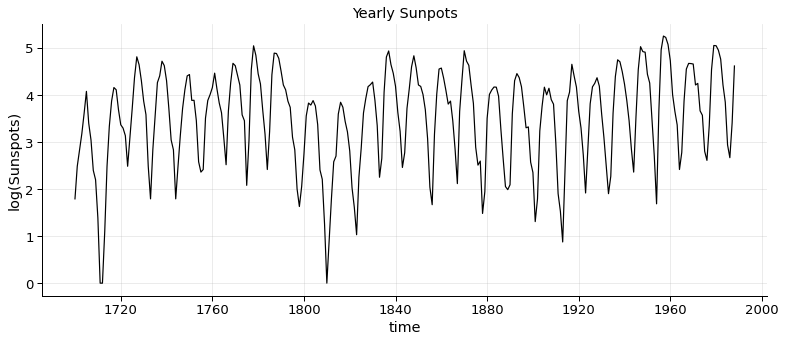

In [44]:
plot_time_series(data.index, data.log_transformation, title= "Yearly Sunpots", ylabel= "log(Sunspots)")

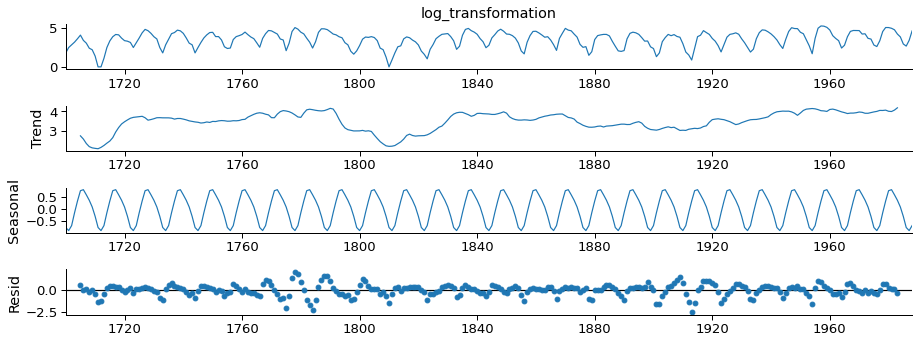

In [92]:
seasonal_plot= seasonal_decompose(data.log_transformation, period= 11).plot()

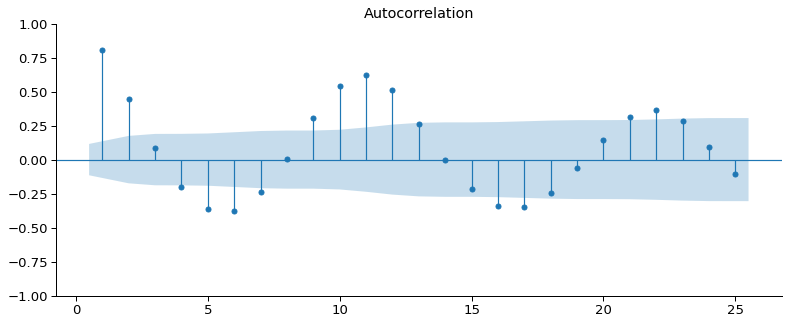

In [89]:
acf= plot_acf(data.log_transformation, zero= False)

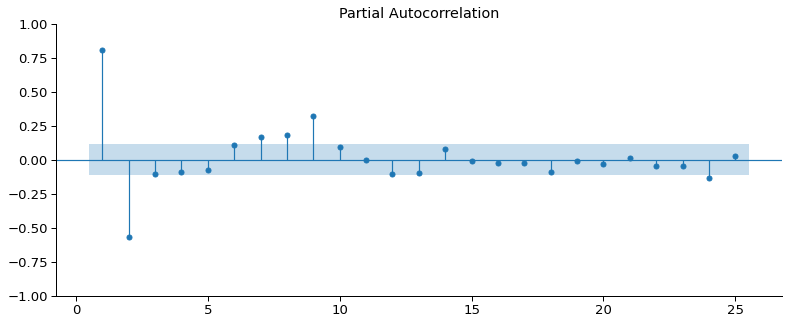

In [90]:
pacf= plot_pacf(data.log_transformation, zero= False)

Differencing

In [95]:
data['lag_11']= data.log_transformation.shift(11)
data['seasonal_diff'] = data.log_transformation - data['lag_11']

In [97]:
data.head(12)

,value,log_transformation,lag_11,seasonal_diff
time,,,,
1700-01-01,5.0,1.791759,NaN,NaN
1701-01-01,11.0,2.484907,NaN,NaN
1702-01-01,16.0,2.833213,NaN,NaN
1703-01-01,23.0,3.178054,NaN,NaN
1704-01-01,36.0,3.610918,NaN,NaN
1705-01-01,58.0,4.077537,NaN,NaN
1706-01-01,29.0,3.401197,NaN,NaN
1707-01-01,20.0,3.044522,NaN,NaN
1708-01-01,10.0,2.397895,NaN,NaN


Test-statistics          -4.127070
p-value                   0.000873
Lags-used                12.000000
Observation-used        265.000000
Critical value (1%)      -3.455270
Critical value (5%)      -2.872509
Critical value (10%)     -2.572615
dtype: float64


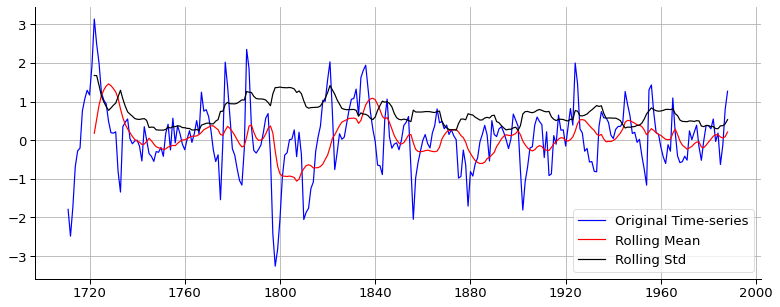

In [98]:
dickey_fuller_test(data['seasonal_diff'].dropna())

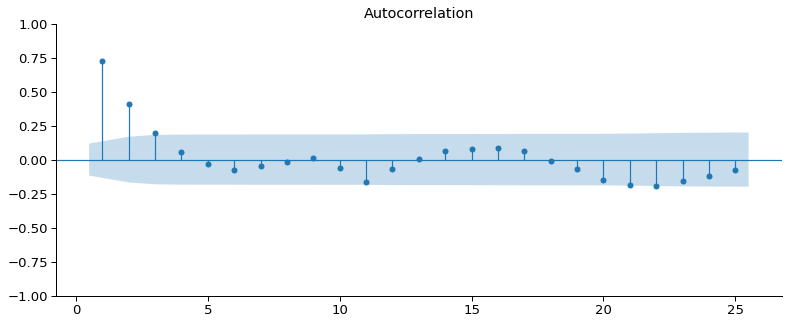

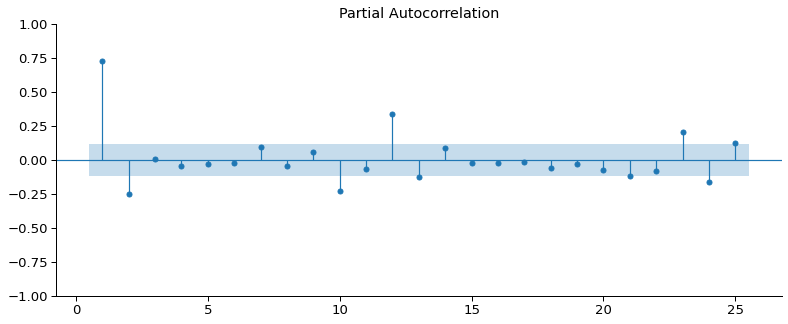

In [100]:
acf_seasonal_diff= plot_acf(data['seasonal_diff'].dropna(), zero= False)
pacf_seasonal_diff= plot_pacf(data['seasonal_diff'].dropna(), zero= False)

## Start with a very simple model

In [101]:
start_model= SARIMAX(data.log_transformation, order= (0,0,0), seasonal_order= (0,1,0,12), trend= 'c').fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33071D+00    |proj g|=  1.01987D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     10      1     0     0   1.019D-05   1.331D+00
  F =   1.3307099952842452     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


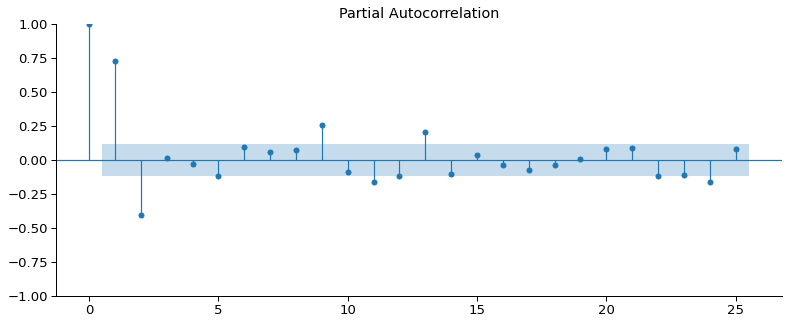

In [103]:
pacf_residuals= plot_pacf(start_model.resid[start_model.loglikelihood_burn:])

In [105]:
auto_model= pm.auto_arima(data.log_transformation,
                          start_p= 0, max_p= 3, 
                          d= 0,
                          start_q= 0, max_q= 3,
                          m= 11, 
                          seasonal= True, 
                          start_P= 0,
                          D= 1, 
                          trace= True, error_action= 'ignore', suppress_warnings= True, stepwise= True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[11] intercept   : AIC=694.412, Time=0.32 sec
 ARIMA(0,0,0)(0,1,0)[11] intercept   : AIC=708.047, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[11] intercept   : AIC=464.732, Time=0.35 sec
 ARIMA(0,0,1)(0,1,1)[11] intercept   : AIC=501.605, Time=0.50 sec
 ARIMA(0,0,0)(0,1,0)[11]             : AIC=707.239, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[11] intercept   : AIC=495.304, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[11] intercept   : AIC=450.988, Time=1.04 sec
 ARIMA(1,0,0)(2,1,1)[11] intercept   : AIC=inf, Time=4.18 sec
 ARIMA(1,0,0)(1,1,1)[11] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(0,0,0)(2,1,0)[11] intercept   : AIC=688.783, Time=0.59 sec
 ARIMA(2,0,0)(2,1,0)[11] intercept   : AIC=425.830, Time=1.35 sec
 ARIMA(2,0,0)(1,1,0)[11] intercept   : AIC=443.928, Time=0.51 sec
 ARIMA(2,0,0)(2,1,1)[11] intercept   : AIC=inf, Time=4.47 sec
 ARIMA(2,0,0)(1,1,1)[11] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(3,0,0)(2,1,0)[11] intercept   : AIC=427.82

In [108]:
print('Order: {} Seasonal order: {}'.format(auto_model.order, auto_model.seasonal_order))

Order: (2, 0, 0) Seasonal order: (2, 1, 0, 11)


In [110]:
auto_model= SARIMAX(data.log_transformation, order= (2,0,0), seasonal_order= (2,1,0,11), trend= 'c').fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75108D-01    |proj g|=  3.41480D-01


 This problem is unconstrained.



At iterate    5    f=  7.19331D-01    |proj g|=  5.82869D-02

At iterate   10    f=  7.15973D-01    |proj g|=  4.94704D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     16      1     0     0   6.078D-05   7.160D-01
  F =  0.71596866225929334     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


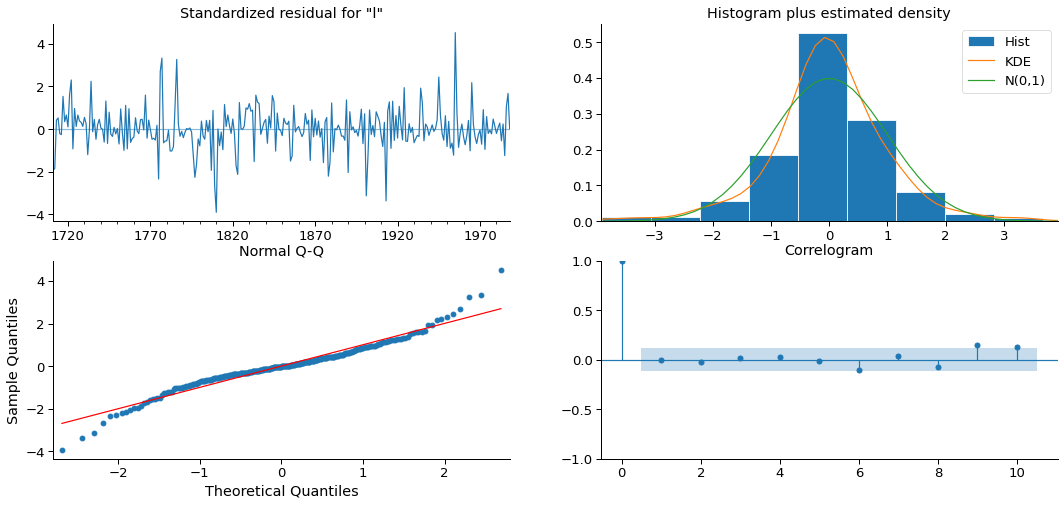

In [117]:
auto_diag= auto_model.plot_diagnostics(figsize= (18,8))